In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys
import os
from pathlib import Path
import warnings
from IPython.display import clear_output

# Get the parent directory and add it to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

warnings.filterwarnings("ignore")

from data_builder import TimeSeriesBuilder, read_trans, read_labels
from utils import read_data, set_seed, easy_test
from models import Model
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from training import train, test
from tqdm import tqdm
import pandas as pd

### 1. Generate time-series by referring to a base gene

In [8]:
# load transcripts and cell types
folder = '../../Xenium/BreastS1R1/'
data_folder = folder + 'TimeSeries/'
save_path = folder + 'ReferredTimeSeries/'
cell_types = read_labels(filename=folder + 'Cell_Barcode_Type_Matrices.xlsx', sheet='Xenium R1 Fig1-5 (supervised)')
# Fetch the list of genes
gene_list = [f.split('_')[0] for f in os.listdir(data_folder) if f.endswith('.csv')]
gene_list = sorted(list(set(gene_list)))
# set base gene
base_gene = 'GATA3'
gene_list.remove(base_gene)
refer_cell_ids = pd.read_csv(data_folder + base_gene + '_ids.csv').values

for i in range(len(gene_list)):
    gene = gene_list[i]
    clear_output(wait=True)
    print(f'Processing the {i+1}-th gene: {gene}')
    transcripts = read_trans(folder + 'MoleculesPerGene/' + gene + '.csv')
    num_cells = transcripts['cell_id'].nunique()
    # Build time series
    tsb = TimeSeriesBuilder(transcripts, cell_types)
    tsb.run(num_samples=int(num_cells/5), save_path=save_path, gene=gene, method='refer', reference_ids=refer_cell_ids)

Processing the 221-th gene: ZNF562
Building cell dictionaries
Build cell feature vectors
13305 time-series samples of ZNF562 generated


### 2. Check delay effect

Train another gene with the series built from the base gene paths.

In [10]:
folder = '../../Xenium/BreastS1R1/'
data_folder = folder + 'ReferredTimeSeries/'
model_folder = folder + 'ReferredModels/'

# Set parameters
SEQ_LEN = 20
dim_inputs = 10
hidden_size = 100
latent_size = 100

batch_size = 1024
base_lr = 0.01
lr_step = 10
num_epochs = 100

gene = 'FOXA1'
# data loading and training
data_path = data_folder + gene + '_data.csv'
locs_path = data_folder + gene + '_locs.csv'
data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
train_data = data
train_locs = locs
set_seed(42)
net, _, _ = train(train_data, train_locs, batch_size, base_lr, lr_step, num_epochs, hidden_size, latent_size, SEQ_LEN)
torch.save(net.state_dict(), model_folder + gene + '_model.pth')

Training: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Test on both genes and check delay effect

In [24]:
_, generation, trans_status, _ = easy_test(data_folder, model_folder, gene, SEQ_LEN, dim_inputs, hidden_size, latent_size)

In [25]:
data_folder_base = folder + 'TimeSeries/'
model_folder_base = folder + 'Models/'
base_gene = 'GATA3'
_, generation_base, trans_status_base, _ = easy_test(data_folder_base, model_folder_base, base_gene, SEQ_LEN, dim_inputs, hidden_size, latent_size)

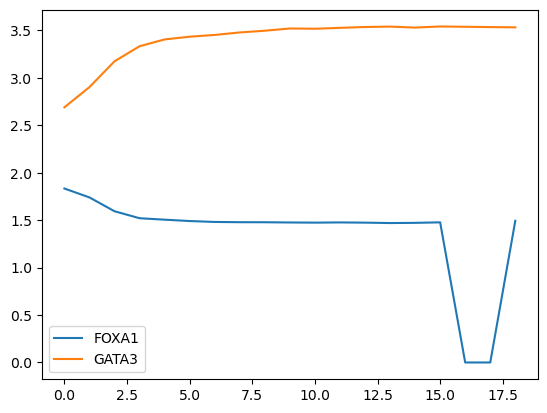

In [210]:
reference = pd.read_csv(data_folder + gene + '_reference.csv')
i = 831
ref = int(reference.iloc[i])
gen = generation[i].view(-1).cpu().detach().numpy()
status = trans_status[i].view(-1).cpu().detach().numpy()
gen_base = generation_base[ref].view(-1).cpu().detach().numpy()
status_base = trans_status_base[ref].view(-1).cpu().detach().numpy()

plt.plot(gen*status, label=gene)
plt.plot(gen_base*status_base, label=base_gene)
plt.legend()
plt.show()